In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

import sys, os
import pandas as pd
from pandas import DataFrame
import datetime
import numpy as np 
import scipy as sc
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold,cross_val_score, learning_curve, cross_validate,train_test_split,GridSearchCV 
from sklearn.feature_selection import RFE, RFECV 
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb

In [2]:
df = pd.concat(map(pd.read_csv, ['football_data.csv']),ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2660 entries, 0 to 2659
Data columns (total 71 columns):
AF5              2589 non-null object
AGD10            2660 non-null float64
AGD20            2660 non-null float64
AGD30            2660 non-null float64
AGD38            2660 non-null float64
AGD5             2660 non-null float64
AGL10            2660 non-null float64
AGL20            2660 non-null float64
AGL30            2660 non-null float64
AGL38            2660 non-null float64
AGL5             2660 non-null float64
AGS10            2660 non-null float64
AGS20            2660 non-null float64
AGS30            2660 non-null float64
AGS38            2660 non-null float64
AGS5             2660 non-null float64
ALF5             2660 non-null float64
AP10             2660 non-null float64
AP20             2660 non-null float64
AP30             2660 non-null float64
AP38             2660 non-null float64
AP5              2660 non-null float64
AwayTeam         2660 non-null objec

In [3]:
def ent(data):
    p_data= data.value_counts()/len(data)
    entropy=sc.stats.entropy(p_data)
    return entropy

In [4]:
#Czy entropia ma zwiazek z korelacja ??
for column in list(df.columns.values):
    print (column+':')
    print (ent(df[column]))

AF5:
5.5028047411924454
AGD10:
3.392540058401983
AGD20:
3.8130019757996108
AGD30:
4.006051190612034
AGD38:
4.038414691086238
AGD5:
2.9363806936601473
AGL10:
3.1153243900476952
AGL20:
3.7286809079993533
AGL30:
4.028501522218098
AGL38:
4.095941859965337
AGL5:
2.546108352313596
AGS10:
3.195947795940452
AGS20:
3.8020464831228056
AGS30:
4.074683721265119
AGS38:
4.136484659747769
AGS5:
2.621039878833137
ALF5:
1.0968684220549123
AP10:
3.2116539462394034
AP20:
3.8046653745371706
AP30:
4.074370937264384
AP38:
4.1370344468587374
AP5:
2.6112500788129496
AwayTeam:
3.3161996564250815
DP10:
3.3592865687485873
DP20:
3.793070174931307
DP30:
3.96906382372272
DP38:
4.00398364333219
DP5:
2.9230274230190356
Day:
3.413353249254687
DaysFromToday:
5.003346345408895
FTR:
1.0656503483448936
GD10:
3.726269085728915
GD20:
4.1776823101610425
GD30:
4.355056461557782
GD38:
4.3841680967256575
GD5:
3.281079726611535
HF5:
5.4966921483437865
HGD10:
3.3949354036568673
HGD20:
3.817439034687535
HGD30:
4.006458546506313
HG

In [5]:
def code_string_values(df):
    team_code = df.AwayTeam.unique()
    team_code = dict(zip(team_code, range(len(team_code))))
    df = df.applymap(lambda s: team_code.get(s) if s in team_code else s)    
    
    form_code = df.HF5.unique()
    form_code2 = df.AF5.unique()
    form_code = np.concatenate((form_code, form_code2))
    
    form_code= dict(zip(form_code, range(len(form_code))))
    
    to_code = df.copy()
    to_code = to_code.applymap(lambda s: form_code.get(s) if s in form_code else s)
    
    df['HF5'] = to_code['HF5']
    df['AF5'] = to_code['AF5']

    return df

df = code_string_values(df)

In [6]:
df_copy = df.copy()

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(y_test.value_counts()['H']/len(y_test))
print(y_train.value_counts()['H']/len(y_train))
print('\n')
print(y_test.value_counts()['D']/len(y_test))
print(y_train.value_counts()['D']/len(y_train))
print('\n')
print(y_test.value_counts()['A']/len(y_test))
print(y_train.value_counts()['A']/len(y_train))

0.4699248120300752
0.44877819548872183


0.2236842105263158
0.2551691729323308


0.30639097744360905
0.29605263157894735


In [8]:
df_copy = df.copy()

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=2019)

In [9]:
classifier = LogisticRegression() 
classifier = classifier.fit(X_train,y_train)
print('Accuracy of logistic regression classifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))

Accuracy of logistic regression classifier on test validation set: 0.515


In [10]:
X = X_train.copy()
y = y_train.copy()

for c in range(5):
    print("seed ",c)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=c)

    classifier = LogisticRegression()
    classifier.fit(Xtrain, ytrain)
    print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(classifier.score(Xtrain, ytrain)))
    print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(classifier.score(Xtest, ytest)))

seed  0
Accuracy of logistic regression classifier on train set: 0.5500
Accuracy of logistic regression classifier on test set: 0.5164
seed  1
Accuracy of logistic regression classifier on train set: 0.5534
Accuracy of logistic regression classifier on test set: 0.5117
seed  2
Accuracy of logistic regression classifier on train set: 0.5326
Accuracy of logistic regression classifier on test set: 0.5368
seed  3
Accuracy of logistic regression classifier on train set: 0.5473
Accuracy of logistic regression classifier on test set: 0.5133
seed  4
Accuracy of logistic regression classifier on train set: 0.5433
Accuracy of logistic regression classifier on test set: 0.5383


In [11]:
X = X_train.copy()
y = y_train.copy()

classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation sets is %2.3f" % scores['test_score'].mean())

ytest = DataFrame(y_validation)
ytrain = DataFrame(y_train)

for i in range(10):
    print('Number of estimator ',i)
    print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(scores['test_score'][i]))
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(scores['estimator'][i].score(X_validation, ytest)))
    print('\n')

LogisticRegression average accuracy for cross-validation sets is 0.515
Number of estimator  0
Accuracy of logistic regression classifier on validation set: 0.54
Accuracy of logistic regression classifier on test set: 0.51


Number of estimator  1
Accuracy of logistic regression classifier on validation set: 0.52
Accuracy of logistic regression classifier on test set: 0.51


Number of estimator  2
Accuracy of logistic regression classifier on validation set: 0.47
Accuracy of logistic regression classifier on test set: 0.52


Number of estimator  3
Accuracy of logistic regression classifier on validation set: 0.50
Accuracy of logistic regression classifier on test set: 0.51


Number of estimator  4
Accuracy of logistic regression classifier on validation set: 0.50
Accuracy of logistic regression classifier on test set: 0.51


Number of estimator  5
Accuracy of logistic regression classifier on validation set: 0.51
Accuracy of logistic regression classifier on test set: 0.51


Number of e

In [12]:
def normalize(df):
    colums_to_normalization = list(df.columns.values)
    df[colums_to_normalization] = df[colums_to_normalization].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))
    return df

In [13]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X)

classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

LogisticRegression average accuracy for cross-validation test set is 0.529


In [14]:
for j in range(5):
    for i in range(2):
        X = X_train.copy()
        y = y_train.copy()
        if i == 1:
            X = normalize(X)
            print("After normaliazation :")
        else :
            print("Before normaliazation :")

        classifier = LogisticRegression()
        scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, n_jobs=-1)
        print("Average fitting time %2.3f" % scores['fit_time'].mean())
    print('\n')

Before normaliazation :
Average fitting time 0.875
After normaliazation :
Average fitting time 0.302


Before normaliazation :
Average fitting time 0.891
After normaliazation :
Average fitting time 0.271


Before normaliazation :
Average fitting time 0.895
After normaliazation :
Average fitting time 0.250


Before normaliazation :
Average fitting time 0.856
After normaliazation :
Average fitting time 0.261


Before normaliazation :
Average fitting time 0.811
After normaliazation :
Average fitting time 0.264




In [15]:
def remove_outliers(column):
    elements = np.array(df[column])
    
    mean = np.mean(elements, axis=0)
    sd = np.std(elements, axis=0)
    
    final_list = [x for x in np.array(df[column]) if (x > mean - 3 * sd)]
    return [x for x in final_list if (x < mean + 3 * sd)]

def remove_outliers_for_FTR(df_copy):
    df_copy_Home = df_copy[df_copy['FTR'].isin(['H'])]
    df_copy_Draw = df_copy[df_copy['FTR'].isin(['D'])]
    df_copy_Away = df_copy[df_copy['FTR'].isin(['A'])]

    columns = ['AGD5', 'AGL5', 'AGS20', 'AGS30', 'GD38', 'HGD10', 'HGS10', 'HGS30', 'HGS38', 'LSTPA', 'LSTPD']

    for c in columns :
        df_copy_Home = df_copy_Home[df_copy_Home[c].isin(remove_outliers(c))]
        df_copy_Draw = df_copy_Draw[df_copy_Draw[c].isin(remove_outliers(c))]
        df_copy_Away = df_copy_Away[df_copy_Away[c].isin(remove_outliers(c))]
    
    filepaths = [df_copy_Home,df_copy_Draw,df_copy_Away]
    return pd.concat(filepaths,ignore_index=True)

In [16]:
def print_example_scatter(df,X):
    plt.scatter(df['FTR'], df['AGD5'], color= 'red')
    plt.scatter(X['FTR'], X['AGD5'],alpha=0.25)
    plt.show()

Numbers of rows before removing outliers :  2128
Numbers of rows after removing outliers :  2051


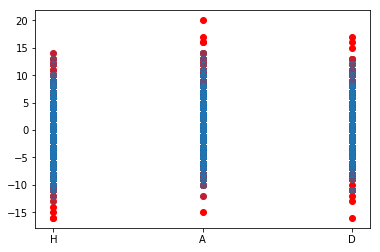

LogisticRegression average accuracy for cross-validation test set is 0.521


In [17]:
X = X_train.copy()
y = y_train.copy()
X['FTR'] = y
print("Numbers of rows before removing outliers : ",len(X))
X = remove_outliers_for_FTR(X)
print("Numbers of rows after removing outliers : ",len(X))
print_example_scatter(df,X)
y = X['FTR']

X = X[X.columns.difference(['FTR'])]
X = normalize(X)
classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

In [18]:
for c in list(X_train):
    print(c)
    print(df['FTR'].corr(df[c],method='spearman'))

AF5
0.013840997610811132
AGD10
-0.21462735779937134
AGD20
-0.24309187489183978
AGD30
-0.24117986223171212
AGD38
-0.23763645620341367
AGD5
-0.20427424184381587
AGL10
0.13746212241115188
AGL20
0.1266533122972552
AGL30
0.10868053251513328
AGL38
0.10322434207253804
AGL5
0.14646918557866845
AGS10
-0.1296383450858232
AGS20
-0.10864468294554269
AGS30
-0.07754640047241805
AGS38
-0.07039512310519637
AGS5
-0.13837884624713043
ALF5
-0.11184125389253341
AP10
-0.1319179120707783
AP20
-0.11017763659690044
AP30
-0.07949971958393198
AP38
-0.07206432250027255
AP5
-0.14823486910566364
AwayTeam
0.12580242366218183
DP10
0.2980352165148844
DP20
0.3315178322554338
DP30
0.3361670704773086
DP38
0.33410092636392424
DP5
0.25472033586877485
DPB10
0.22744739860650007
DPB20
0.2302457492595456
DPB30
0.2302457492595456
DPB40
0.2302457492595456
DPB5
0.19970507918864297
Day
-0.010043659971963437
DaysFromToday
-0.03456006395773041
GD10
0.3208782417328421
GD20
0.3424165694451478
GD30
0.34394803032015786
GD38
0.342565151

In [19]:
correlation_columns = ['DP20','DP30','DP38','GD10','GD20','GD30','GD38','LSTPD']
X = X_train.copy()
y = y_train.copy()
X = X[correlation_columns]

classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

LogisticRegression average accuracy for cross-validation test set is 0.531


In [20]:
def get_RFE_features(estimator,X,y,df_copy,number_of_features):
    rfe = RFE(estimator, number_of_features)
    fit = rfe.fit(X, y)
    f = rfe.get_support(1)
    print(rfe.ranking_,"\n")
    print(X.columns[f],"\n")

    X = X[X.columns[f]]
    return X[X.columns.difference(['FTR'])],rfe

In [21]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X)

X,rfe = get_RFE_features(LogisticRegression(),X,y,df_copy,10)

classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

[49 13 36 20  4  1 38 35 55  5  8 37 12 33  1 16 18 28 17 43 47 50 25 54
 27 26 34 57 44 19  9 10 11 58  6 42  1 32  1 24 53  1 14 52 23 61 30 31
 22 21 59 15  1  1 48 56 39 45  7 40 60 29  1  1  2  1  3 51 46 41] 

Index(['AGD5', 'AGS38', 'GD20', 'GD38', 'HGD10', 'HGS20', 'HGS30', 'HomeTeam',
       'LFD5', 'LSTPD'],
      dtype='object') 

LogisticRegression average accuracy for cross-validation test set is 0.537


Optimal number of features: 11
Selected features: ['AGD5', 'AGS38', 'GD20', 'GD38', 'HGD10', 'HGS20', 'HGS30', 'HomeTeam', 'LFD5', 'LSTPA', 'LSTPD']
LogisticRegression average accuracy for cross-validation test set is 0.539


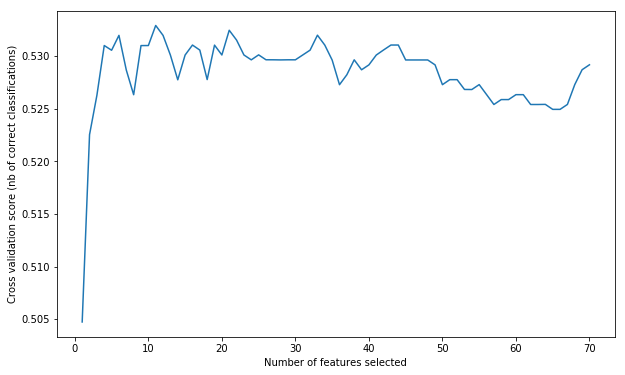

In [22]:
X = X_train.copy()
y = y_train.copy()
X = normalize(X)

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))
rfecv_selected_featues = rfecv.support_
X = X[X.columns[rfecv.support_]]

classifier = LogisticRegression()
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [23]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X[X.columns.difference(['FTR'])])

X = X[X.columns[rfecv_selected_featues]]

param_grid = [
  {'penalty': ['l2'], 'solver': [ 'newton-cg','lbfgs', 'sag', 'saga'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr', 'multinomial'], 'class_weight' : [None, 'balanced']},
    
  {'penalty': ['l2'], 'solver': ['liblinear'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr'], 'class_weight' : [None, 'balanced']},
    
  {'penalty': ['l1'], 'solver': ['saga'],'C': [0.001,0.01,0.1,1,10,100,1000],
  'multi_class' :  ['ovr', 'multinomial'], 'class_weight' : [None, 'balanced']},
 ]

model_lr = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=10)
model_lr.fit(X, y)
clf = model_lr.best_estimator_
print('The best found score and model:')
print (model_lr.best_score_, model_lr.best_params_) 

The best found score and model:
0.5390037593984962 {'C': 1, 'class_weight': None, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}


In [24]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X[X.columns.difference(['FTR'])])

X = X[X.columns[rfecv_selected_featues]]

classifier = LogisticRegression(C= 1,penalty= 'l2',class_weight= None, multi_class= 'ovr',solver= 'liblinear') 
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

LogisticRegression average accuracy for cross-validation test set is 0.539


In [25]:
df_copy = df.copy()

y = df_copy['FTR']

df_copy = df_copy[df_copy.columns.difference(['FTR'])]
df_copy = df_copy[df_copy.columns[rfecv_selected_featues]]

df_copy = normalize(df_copy[df_copy.columns.difference(['FTR'])])

X = df_copy[df_copy.columns.difference(['FTR'])]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=2019)

In [26]:
classifier = LogisticRegression(C= 1,penalty= 'l2',class_weight= None, multi_class= 'ovr',solver= 'liblinear') 
classifier = classifier.fit(X_train,y_train)
print('Accuracy of logistic regression classifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of logistic regression classifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

Accuracy of logistic regression classifier on test validation set: 0.526
Accuracy of logistic regression classifier on train set: 0.541

 Confusion matrix: 
[[ 92   0  64]
 [ 47   0  79]
 [ 62   0 188]] 

Classification report: 
              precision    recall  f1-score   support

           A       0.46      0.59      0.52       156
           D       0.00      0.00      0.00       126
           H       0.57      0.75      0.65       250

   micro avg       0.53      0.53      0.53       532
   macro avg       0.34      0.45      0.39       532
weighted avg       0.40      0.53      0.46       532



<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

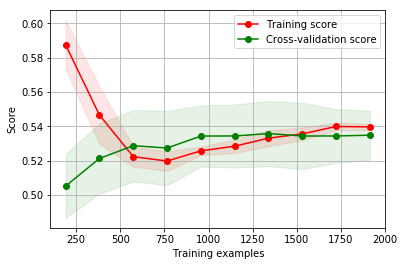

In [27]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=10, scoring='accuracy', obj_line=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt

plot_learning_curve(LogisticRegression(C= 1,penalty= 'l1',class_weight= None, multi_class= 'ovr',solver= 'saga') , X_train, y_train )

In [49]:
df_copy = df.copy()

X = df_copy[df_copy.columns.difference(['FTR'])]
y = df_copy['FTR']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=2019)

In [30]:
classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.522


In [31]:
X = X_train.copy()
y = y_train.copy()

for c in range(5):
    print("seed ",c)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=c)

    classifier = xgb.XGBClassifier(nthread =-1)
    classifier.fit(Xtrain, ytrain)
    print('Accuracy of ',classifier.__class__.__name__,' classifier on train set: {:.4f}'.format(classifier.score(Xtrain, ytrain)))
    print('Accuracy of ',classifier.__class__.__name__,' classifier on test set: {:.4f}'.format(classifier.score(Xtest, ytest)))

seed  0
Accuracy of  XGBClassifier  classifier on train set: 0.7529
Accuracy of  XGBClassifier  classifier on test set: 0.5227
seed  1
Accuracy of  XGBClassifier  classifier on train set: 0.7428
Accuracy of  XGBClassifier  classifier on test set: 0.4992
seed  2
Accuracy of  XGBClassifier  classifier on train set: 0.7233
Accuracy of  XGBClassifier  classifier on test set: 0.5336
seed  3
Accuracy of  XGBClassifier  classifier on train set: 0.7206
Accuracy of  XGBClassifier  classifier on test set: 0.5211
seed  4
Accuracy of  XGBClassifier  classifier on train set: 0.7139
Accuracy of  XGBClassifier  classifier on test set: 0.5321


In [32]:
X = X_train.copy()
y = y_train.copy()

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation sets is %2.3f" % scores['test_score'].mean())

ytest = DataFrame(y_validation)
ytrain = DataFrame(y_train)

for i in range(10):
    print('Number of estimator ',i)
    print('Accuracy of ',classifier.__class__.__name__,' classifier on validation set: {:.2f}'.format(scores['test_score'][i]))
    print('Accuracy of ',classifier.__class__.__name__,' classifier on test set: {:.2f}'.format(scores['estimator'][i].score(X_validation, ytest)))
    print('\n')

XGBClassifier average accuracy for cross-validation sets is 0.522
Number of estimator  0
Accuracy of  XGBClassifier  classifier on validation set: 0.57
Accuracy of  XGBClassifier  classifier on test set: 0.52


Number of estimator  1
Accuracy of  XGBClassifier  classifier on validation set: 0.49
Accuracy of  XGBClassifier  classifier on test set: 0.53


Number of estimator  2
Accuracy of  XGBClassifier  classifier on validation set: 0.49
Accuracy of  XGBClassifier  classifier on test set: 0.52


Number of estimator  3
Accuracy of  XGBClassifier  classifier on validation set: 0.47
Accuracy of  XGBClassifier  classifier on test set: 0.51


Number of estimator  4
Accuracy of  XGBClassifier  classifier on validation set: 0.50
Accuracy of  XGBClassifier  classifier on test set: 0.48


Number of estimator  5
Accuracy of  XGBClassifier  classifier on validation set: 0.58
Accuracy of  XGBClassifier  classifier on test set: 0.51


Number of estimator  6
Accuracy of  XGBClassifier  classifier on

In [33]:
X = X_train.copy()
y = y_train.copy()

X = normalize(X)

model = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.522


In [34]:
for j in range(5):
    for i in range(2):
        X = X_train.copy()
        y = y_train.copy()
        if i == 1:
            X = normalize(X)
            print("After normaliazation :")
        else :
            print("Before normaliazation :")

        classifier = xgb.XGBClassifier(nthread =-1)
        scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, n_jobs=-1)
        print("Average fitting time %2.3f" % scores['fit_time'].mean())
    print('\n')

Before normaliazation :
Average fitting time 2.069
After normaliazation :
Average fitting time 2.126


Before normaliazation :
Average fitting time 2.018
After normaliazation :
Average fitting time 2.081


Before normaliazation :
Average fitting time 2.153
After normaliazation :
Average fitting time 2.293


Before normaliazation :
Average fitting time 2.167
After normaliazation :
Average fitting time 2.306


Before normaliazation :
Average fitting time 2.051
After normaliazation :
Average fitting time 2.157




Numbers of rows before removing outliers :  2128
Numbers of rows after removing outliers :  2051


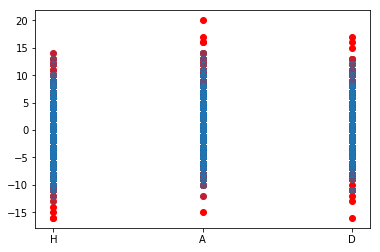

XGBClassifier average accuracy for cross-validation test set is 0.503


In [35]:
X = X_train.copy()
y = y_train.copy()
X['FTR'] = y
print("Numbers of rows before removing outliers : ",len(X))
X = remove_outliers_for_FTR(X)
print("Numbers of rows after removing outliers : ",len(X))
print_example_scatter(df,X)
y = X['FTR']

X = X[X.columns.difference(['FTR'])]

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

In [36]:
correlation_columns = ['DP20','DP30','DP38','GD10','GD20','GD30','GD38','LSTPD']
X = X_train.copy()
y = y_train.copy()
X = X[correlation_columns]

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.521


In [37]:
X = X_train.copy()
y = y_train.copy()

X,rfe = get_RFE_features(LogisticRegression(),X,y,df_copy,10)

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

[60 38 34  1  1  4 53 35 49 19 27 45 10  9 25 22  3 31 26  2  1 23 50 20
 13  1  1 47  1 30  5  1 24 57 55 54 12 28 11 42 61 21  7 29 48 51 46 44
  1  1 59 56 32 17 16 43 39 15  8 37 18 36 33 14 40  1 41  6 52 58] 

Index(['AGD30', 'AGD38', 'AP38', 'DP30', 'DP38', 'DPB10', 'DPB40', 'HGL30',
       'HGL38', 'LSTPD'],
      dtype='object') 

XGBClassifier average accuracy for cross-validation test set is 0.515


Optimal number of features: 10
Selected features: ['AF5', 'AGD38', 'AGL30', 'AwayTeam', 'Day', 'DaysFromToday', 'GD30', 'HF5', 'HGD30', 'LSTPD']
XGBClassifier average accuracy for cross-validation test set is 0.525


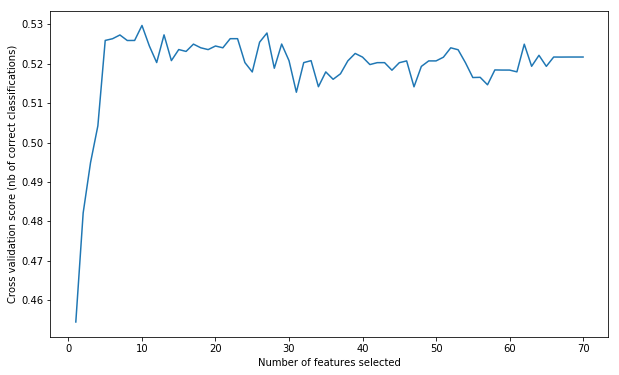

In [38]:
X = X_train.copy()
y = y_train.copy()

rfecv = RFECV(estimator=xgb.XGBClassifier(nthread =-1), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))
rfecv_selected_featues = rfecv.support_
X = X[X.columns[rfecv.support_]]

classifier = xgb.XGBClassifier(nthread =-1)
scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', 
                        return_train_score=False, return_estimator=True, n_jobs=-1)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [39]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(nthread =-1)
fit_params={'early_stopping_rounds': 20, 
            'verbose': True,
            'eval_set': [[X, y]]}

scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False,
                        return_estimator=True, n_jobs=-1,fit_params = fit_params)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.528


In [40]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

parameters = {
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'learning_rate':[0.2, 0.3, 0.4, 0.5]
        }

fit_params={'early_stopping_rounds': 20, 
            'verbose': True,
            'eval_set': [[X, y]]}

classifier = xgb.XGBClassifier(nthread =-1)
with HiddenPrints():
    grid_obj = GridSearchCV(classifier,
                            param_grid=parameters,
                             fit_params=fit_params,cv=5,n_jobs=-1 )
    grid_obj.fit(X, y)
    tree_model = grid_obj.best_estimator_

print (grid_obj.best_score_, grid_obj.best_params_) 

0.5399436090225563 {'colsample_bytree': 0.6, 'gamma': 5, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8}


In [50]:
X = X_train.copy()
y = y_train.copy()

X = X[X.columns[rfecv_selected_featues]]

classifier = xgb.XGBClassifier(subsample= 0.8, gamma= 5, min_child_weight= 1, 
                               colsample_bytree= 0.6, max_depth= 3,learning_rate=0.2,nthread =-1)
fit_params={'early_stopping_rounds': 20, 
            'verbose': True,
            'eval_set': [[X, y]]}

scores = cross_validate(classifier, X, y, cv=10, scoring='accuracy', return_train_score=False,
                        return_estimator=True, n_jobs=-1,fit_params = fit_params)
print(classifier.__class__.__name__+" average accuracy for cross-validation test set is %2.3f" % scores['test_score'].mean())

XGBClassifier average accuracy for cross-validation test set is 0.540


In [51]:
df_copy = df.copy()

y = df_copy['FTR']

X = df_copy[df_copy.columns.difference(['FTR'])]
X = X[X.columns[rfecv_selected_featues]]

X = X[X.columns.difference(['FTR'])]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=2019)

In [52]:
classifier = xgb.XGBClassifier(subsample= 0.8, gamma= 5, min_child_weight= 1, 
                               colsample_bytree= 0.6, max_depth= 3,learning_rate=0.2,
                               nthread =-1)

classifier = classifier.fit(X_train,y_train,early_stopping_rounds= 20,verbose= True,eval_set= [[X, y]])

print('Accuracy of logistic regression classifier on test validation set: {:.3f}'
      .format(classifier.score(X_validation, y_validation)))
print('Accuracy of logistic regression classifier on train set: {:.3f}'.format(classifier.score(X_train, y_train)))

y_pred = classifier.predict(X_validation)
print('\n','Confusion matrix: ')
print(confusion_matrix(y_validation, y_pred),'\n')
print('Classification report: ')
print(classification_report(y_validation, y_pred))

[0]	validation_0-merror:0.470677
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.453008
[2]	validation_0-merror:0.455263
[3]	validation_0-merror:0.462782
[4]	validation_0-merror:0.455639
[5]	validation_0-merror:0.456767
[6]	validation_0-merror:0.460902
[7]	validation_0-merror:0.462782
[8]	validation_0-merror:0.460526
[9]	validation_0-merror:0.461654
[10]	validation_0-merror:0.462406
[11]	validation_0-merror:0.461278
[12]	validation_0-merror:0.462782
[13]	validation_0-merror:0.46015
[14]	validation_0-merror:0.460526
[15]	validation_0-merror:0.460902
[16]	validation_0-merror:0.460902
[17]	validation_0-merror:0.461278
[18]	validation_0-merror:0.458271
[19]	validation_0-merror:0.460902
[20]	validation_0-merror:0.459023
[21]	validation_0-merror:0.460902
Stopping. Best iteration:
[1]	validation_0-merror:0.453008

Accuracy of logistic regression classifier on test validation set: 0.551
Accuracy of logistic regression classifier on train set: 0.546


[0]	validation_0-merror:0.468515	validation_1-merror:0.479323
[1]	validation_0-merror:0.453947	validation_1-merror:0.449248
[2]	validation_0-merror:0.455827	validation_1-merror:0.453008
[3]	validation_0-merror:0.460526	validation_1-merror:0.471804
[4]	validation_0-merror:0.454887	validation_1-merror:0.458647
[5]	validation_0-merror:0.457237	validation_1-merror:0.454887
[6]	validation_0-merror:0.458647	validation_1-merror:0.469925
[7]	validation_0-merror:0.459117	validation_1-merror:0.477444
[8]	validation_0-merror:0.456297	validation_1-merror:0.477444
[9]	validation_0-merror:0.459117	validation_1-merror:0.471804
[10]	validation_0-merror:0.458647	validation_1-merror:0.477444
[11]	validation_0-merror:0.457707	validation_1-merror:0.475564
[12]	validation_0-merror:0.458647	validation_1-merror:0.479323
[13]	validation_0-merror:0.455357	validation_1-merror:0.479323
[14]	validation_0-merror:0.455827	validation_1-merror:0.479323
[15]	validation_0-merror:0.456297	validation_1-merror:0.479323
[1

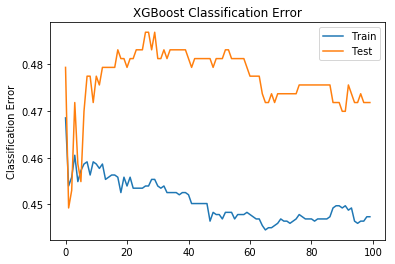

In [55]:
unique = df.FTR.unique()
result_code = dict(zip(unique, range(len(unique))))
def code_FTR(df):
    df = df.applymap(lambda s: result_code.get(s) if s in result_code else s)
    return df

classifier = xgb.XGBClassifier(subsample= 0.8, gamma= 5, min_child_weight= 1, 
                               colsample_bytree= 0.6, max_depth= 3,learning_rate=0.2,nthread =-1)
eval_set = [(X_train, y_train), (X_validation, y_validation)]
classifier.fit(X_train, y_train, eval_metric=["merror"], eval_set=eval_set, verbose=True)

y_pred = classifier.predict(X_validation)

y_pred = DataFrame(y_pred)
y_pred = code_FTR(y_pred)

predictions = [round(value) for value in y_pred]

results = classifier.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()